### ETL

In [27]:
#Librerias
import pandas as pd
from INEGIpy import Indicadores
from sie_banxico import SIEBanxico
import matplotlib.pyplot as plt
import yaml

Importación de API's keys

In [58]:
# Ruta relativa al yaml
ruta_archivo_yaml = "../config/config.yaml"

# Cargar configuración desde config.yaml
with open(ruta_archivo_yaml, "r") as yamlfile:
    config = yaml.safe_load(yamlfile)

# Acceder al token específico para Banxico
token_banxico = config['banxico']['token'].strip()
token_inegi = config['inegi']['token'].strip()


Extracción tipo de cambio

In [59]:
# Inicializar el cliente de la API con el token y los IDs de las series a consultar
t_cambio = SIEBanxico(token=token_banxico, id_series=['SF43718'], language='en')

# Obtiene los datos de la serie en el rango de fechas deseado
data_t_cambio = t_cambio.get_timeseries_range(init_date='2000-12-31', end_date='2024-03-18')

# Transforma los datos en un DataFrame de Pandas
df = pd.DataFrame(data_t_cambio['bmx']['series'][0]['datos'])

# Cambia el nombre de la columna 'dato' a 'peso_por_dolar'
df.rename(columns={'dato': 'peso_por_dolar'}, inplace=True)

# Convierte la columna 'fecha' al formato deseado
df['fecha'] = pd.to_datetime(df['fecha'], format='%d/%m/%Y').dt.strftime('%Y-%m-%d')

# Muestra las primeras filas del DataFrame con las modificaciones
print(df.head())

# Guarda los datos en un archivo CSV con las modificaciones
df.to_csv("../data/raw/tipo_de_cambio.csv", index=False)


        fecha peso_por_dolar
0  2001-01-02         9.7140
1  2001-01-03         9.8340
2  2001-01-04         9.7080
3  2001-01-05         9.7546
4  2001-01-08         9.6900


Extracción tasa de interés

In [60]:
# Inicializar el cliente de la API para la tasa de interés
t_interes = SIEBanxico(token=token_banxico, id_series=['SF61745'], language='en')

# Obtiene los datos de la serie en el rango de fechas deseado para la tasa de interés
data_t_interes = t_interes.get_timeseries_range(init_date='2000-12-31', end_date='2024-03-18')

# Transforma los datos de la tasa de interés en un DataFrame de Pandas
df_t_interes = pd.DataFrame(data_t_interes['bmx']['series'][0]['datos'])

# Cambia el nombre de la columna 'dato' a 'tasa_de_interes'
df_t_interes.rename(columns={'dato': 'tasa_de_interes'}, inplace=True)

# Convierte la columna 'fecha' al formato deseado
df_t_interes['fecha'] = pd.to_datetime(df_t_interes['fecha'], format='%d/%m/%Y').dt.strftime('%Y-%m-%d')

# Muestra las primeras filas del DataFrame de la tasa de interés
print(df_t_interes.head())

# Guarda los datos de la tasa de interés en un archivo CSV
df_t_interes.to_csv("../data/raw/tasa_de_interes.csv", index=False)


        fecha tasa_de_interes
0  2008-01-21          7.5000
1  2008-01-22          7.5000
2  2008-01-23          7.5000
3  2008-01-24          7.5000
4  2008-01-25          7.5000


Extracción del Índice e Precios y Cotizaciones (Inflación)

In [61]:
inegi = Indicadores(token_inegi)

# Reemplaza '6206972689' con el ID del indicador que deseas consultar
df_inpc = inegi.obtener_df(indicadores=['628194'], 
                      nombres=['INPC'], 
                      inicio='2000-01-01', 
                      fin='2024-02-01')

# Transforma la columna de fechas en un objeto datetime, especificando el formato
df_inpc.index = pd.to_datetime(df_inpc.index, format='%Y-%m-%d')

# Imprime las primeras y últimas filas del DataFrame para verificar
print(df_inpc.head())
print(df_inpc.tail())

df_inpc.to_csv("../data/raw/inflacion.csv", index=True, index_label='fecha')


                 INPC
fechas               
2000-01-01  44.930830
2000-02-01  45.329380
2000-03-01  45.580681
2000-04-01  45.840018
2000-05-01  46.011379
               INPC
fechas             
2023-10-01  130.609
2023-11-01  131.445
2023-12-01  132.373
2024-01-01  133.555
2024-02-01  133.681


C:\Users\antap\AppData\Roaming\Python\Python39\site-packages\INEGIpy\_indicadores.py:108: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.set_index(pd.to_datetime(df.fechas),inplace=True, drop=True)


Procesamiento de datos

In [62]:

# Leer archivos
df_tipo_cambio = pd.read_csv("../data/raw/tipo_de_cambio.csv")
df_tasa_interes = pd.read_csv("../data/raw/tasa_de_interes.csv")
df_inflacion = pd.read_csv("../data/raw/inflacion.csv")

# Buscar y eliminar duplicados
df_tipo_cambio = df_tipo_cambio.drop_duplicates()
df_tasa_interes = df_tasa_interes.drop_duplicates()
df_inflacion = df_inflacion.drop_duplicates()

# Buscar y manejar valores faltantes, por ejemplo, eliminándolos
df_tipo_cambio = df_tipo_cambio.dropna()
df_tasa_interes = df_tasa_interes.dropna()
df_inflacion = df_inflacion.dropna()

# Leer la  'fecha'y asegurarse del formato datetime
df_tipo_cambio['fecha'] = pd.to_datetime(df_tipo_cambio['fecha'])
df_tasa_interes['fecha'] = pd.to_datetime(df_tasa_interes['fecha'])
df_inflacion['fecha'] = pd.to_datetime(df_inflacion['fecha'])

# Encuentra la fecha mínima y máxima común
min_fecha = max(df_tipo_cambio['fecha'].min(), df_tasa_interes['fecha'].min(), df_inflacion['fecha'].min())
max_fecha = min(df_tipo_cambio['fecha'].max(), df_tasa_interes['fecha'].max(), df_inflacion['fecha'].max())

# Filtra cada DataFrame por el rango de fechas común
df_tipo_cambio = df_tipo_cambio[(df_tipo_cambio['fecha'] >= min_fecha) & (df_tipo_cambio['fecha'] <= max_fecha)]
df_tasa_interes = df_tasa_interes[(df_tasa_interes['fecha'] >= min_fecha) & (df_tasa_interes['fecha'] <= max_fecha)]
df_inflacion = df_inflacion[(df_inflacion['fecha'] >= min_fecha) & (df_inflacion['fecha'] <= max_fecha)]

# Guarda los DataFrames filtrados
df_tipo_cambio.to_csv("../data/processed/tipo_de_cambio.csv", index=False)
df_tasa_interes.to_csv("../data/processed/tasa_de_interes.csv", index=False)
df_inflacion.to_csv("../data/processed/inflacion.csv", index=False)



Gráficas de las series de tiempo

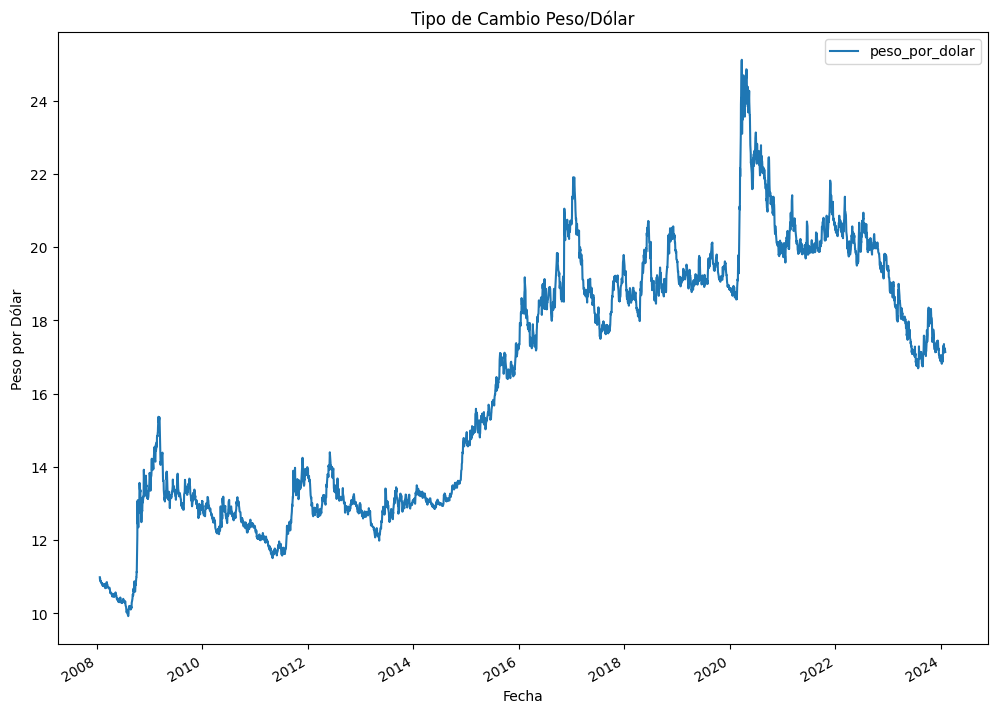

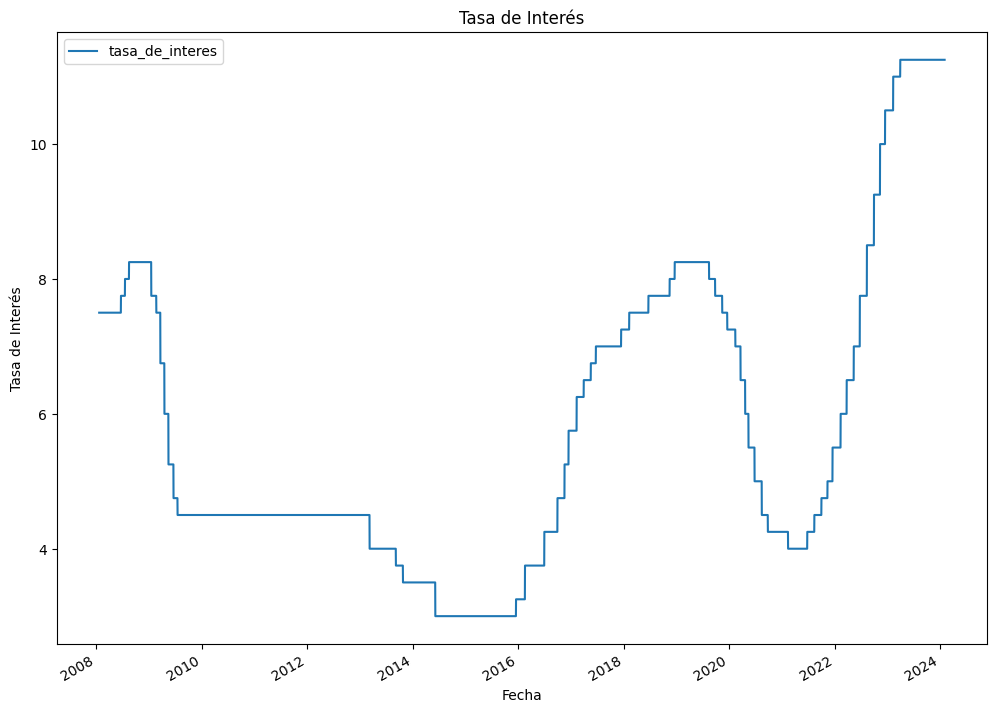

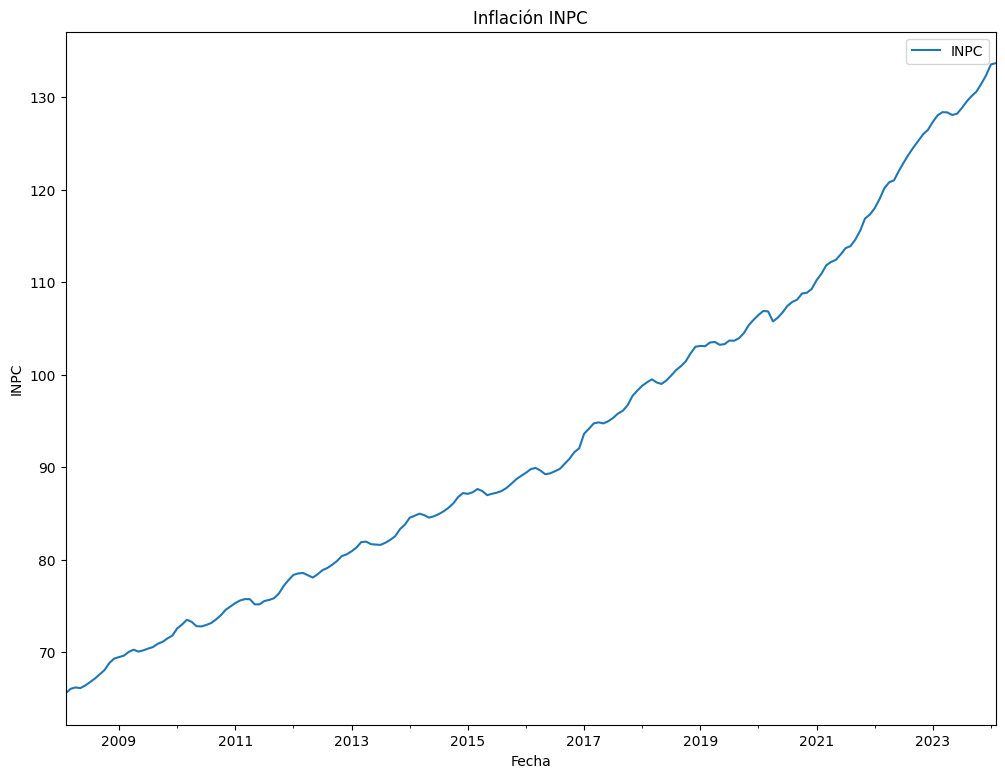

In [63]:


df_tipo_cambio.set_index('fecha', inplace=True)
df_tasa_interes.set_index('fecha', inplace=True)
df_inflacion.set_index('fecha', inplace=True)

# Gráfica tipo de cambio
df_tipo_cambio.plot(figsize=(12, 9), title='Tipo de Cambio Peso/Dólar')
plt.xlabel('Fecha')
plt.ylabel('Peso por Dólar')
plt.show()

# Gráfica tasa de interés
df_tasa_interes.plot(figsize=(12, 9), title='Tasa de Interés')
plt.xlabel('Fecha')
plt.ylabel('Tasa de Interés')
plt.show()

# Gráfica inflación (INPC)
df_inflacion.plot(figsize=(12, 9), title='Inflación INPC')
plt.xlabel('Fecha')
plt.ylabel('INPC')
plt.show()

Load

In [1]:
# Abres un cliente de S3
import boto3
session = boto3.Session(profile_name='arquitectura')
s3 = session.client('s3')

In [2]:
# Crea un nuevo Bucket
BUCKET_NAME = "itam-analytics-jantonio"
s3.create_bucket(Bucket=BUCKET_NAME)

{'ResponseMetadata': {'RequestId': 'WQVZTMSTQ4J1EKEB',
  'HostId': 'O12vhZcLmVayO3AVvMfPDd9l7C10f9Ai6TAdxGkT6E4jyzdclVZWllPKuLPpH/5j3HWqcfiMibc=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'O12vhZcLmVayO3AVvMfPDd9l7C10f9Ai6TAdxGkT6E4jyzdclVZWllPKuLPpH/5j3HWqcfiMibc=',
   'x-amz-request-id': 'WQVZTMSTQ4J1EKEB',
   'date': 'Wed, 20 Mar 2024 07:09:48 GMT',
   'location': '/itam-analytics-jantonio',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'Location': '/itam-analytics-jantonio'}

In [4]:
# Upload los dos archivos a S3
s3.upload_file(Filename="../data/processed/inflacion.csv", Bucket=BUCKET_NAME, Key="mx_econo_insights/inflacion/inflacion.csv")
s3.upload_file(Filename="../data/processed/tasa_de_interes.csv", Bucket=BUCKET_NAME, Key="mx_econo_insights/tasa_de_interes/tasa_de_interes.csv")
s3.upload_file(Filename="../data/processed/tipo_de_cambio.csv", Bucket=BUCKET_NAME, Key="mx_econo_insights/tipo_de_cambio/tipo_de_cambio.csv")

ELT

In [3]:
from botocore.config import Config
my_config = Config(
    region_name = 'us-east-1'
)

glue = boto3.client('glue', config=my_config)

ELT indicators

In [9]:
response = glue.create_database(
    DatabaseInput={
        'Name': 'indicators',
        'Description': 'Indicadores tasa, inflación y tipo de cambio',
    },
)
response

NoCredentialsError: Unable to locate credentials

Configurar Athena

In [10]:
s3.create_bucket(Bucket="arquitectura-athena-queries-indicators-jantonio")

{'ResponseMetadata': {'RequestId': '1R14S6TDRMPWMME5',
  'HostId': '8aZ0EM1cLqNUKD44nFiGVZb3gnxD2Lre6ZlgfaqWrI3O/U0wCOQCDxpBa9RL1Nrac6uMOPZ9b/E=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': '8aZ0EM1cLqNUKD44nFiGVZb3gnxD2Lre6ZlgfaqWrI3O/U0wCOQCDxpBa9RL1Nrac6uMOPZ9b/E=',
   'x-amz-request-id': '1R14S6TDRMPWMME5',
   'date': 'Wed, 20 Mar 2024 18:45:21 GMT',
   'location': '/arquitectura-athena-queries-indicators-jantonio',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'Location': '/arquitectura-athena-queries-indicators-jantonio'}

## a) Extract y b) Load

### Crear tablas en la base de datos de nuestros CSVs en el data lake

- **Season Guests Table**

In [11]:
import awswrangler as wr

Tabla de Inflación

In [15]:
query = '''
    CREATE EXTERNAL TABLE IF NOT EXISTS `indicators`.`inflacion` (
    `fecha` string,
    `INPC` double
    ) COMMENT "Datos de inflación mensual."
    ROW FORMAT SERDE 'org.apache.hadoop.hive.serde2.lazy.LazySimpleSerDe'
    WITH SERDEPROPERTIES ('field.delim' = ',')
    STORED AS INPUTFORMAT 'org.apache.hadoop.mapred.TextInputFormat' OUTPUTFORMAT 'org.apache.hadoop.hive.ql.io.HiveIgnoreKeyTextOutputFormat'
    LOCATION 's3://itam-analytics-jantonio/mx_econo_insights/inflacion/'
    TBLPROPERTIES ('classification' = 'csv', "skip.header.line.count"="1");
'''

In [16]:
wr.athena.read_sql_query(
    query, 
    database="indicators", 
    ctas_approach=False, 
    boto3_session=session
)

""


Tabla de tasa de interés

In [17]:
query = '''
    CREATE EXTERNAL TABLE IF NOT EXISTS `indicators`.`tasa_de_interes` (
    `fecha` string,
    `tasa_de_interes` double
    ) COMMENT "Datos de tasa de interes diario."
    ROW FORMAT SERDE 'org.apache.hadoop.hive.serde2.lazy.LazySimpleSerDe'
    WITH SERDEPROPERTIES ('field.delim' = ',')
    STORED AS INPUTFORMAT 'org.apache.hadoop.mapred.TextInputFormat' OUTPUTFORMAT 'org.apache.hadoop.hive.ql.io.HiveIgnoreKeyTextOutputFormat'
    LOCATION 's3://itam-analytics-jantonio/mx_econo_insights/tasa_de_interes/'
    TBLPROPERTIES ('classification' = 'csv', "skip.header.line.count"="1");
'''

In [18]:
wr.athena.read_sql_query(
    query, 
    database="indicators", 
    ctas_approach=False, 
    boto3_session=session
)

""


Tabla de tipo de cambio

In [20]:
query = '''
    CREATE EXTERNAL TABLE IF NOT EXISTS `indicators`.`tipo_de_cambio` (
    `fecha` string,
    `tipo_de_cambio` double
    ) COMMENT "Datos de tasa de tipo de cambio."
    ROW FORMAT SERDE 'org.apache.hadoop.hive.serde2.lazy.LazySimpleSerDe'
    WITH SERDEPROPERTIES ('field.delim' = ',')
    STORED AS INPUTFORMAT 'org.apache.hadoop.mapred.TextInputFormat' OUTPUTFORMAT 'org.apache.hadoop.hive.ql.io.HiveIgnoreKeyTextOutputFormat'
    LOCATION 's3://itam-analytics-jantonio/mx_econo_insights/tipo_de_cambio/'
    TBLPROPERTIES ('classification' = 'csv', "skip.header.line.count"="1");
'''

In [21]:
wr.athena.read_sql_query(
    query, 
    database="indicators", 
    ctas_approach=False, 
    boto3_session=session
)

""


### c) Transform

In [22]:
query = '''
    CREATE TABLE IF NOT EXISTS indicators.combined_data AS (
    SELECT 
        i.fecha AS fecha,
        i.INPC AS INPC,
        t.tasa_de_interes AS tasa_de_interes,
        c.tipo_de_cambio AS tipo_de_cambio
    FROM indicators.inflacion i
    LEFT JOIN indicators.tasa_de_interes t ON i.fecha = t.fecha
    LEFT JOIN indicators.tipo_de_cambio c ON i.fecha = c.fecha
    )
'''

wr.athena.read_sql_query(
    query, 
    database="indicators", 
    ctas_approach=False, 
    boto3_session=session
)

""


Analytics

In [23]:
query = '''SELECT * FROM indicators.combined_data'''

In [24]:
tbl_econo_insights = wr.athena.read_sql_query(
    query, 
    database="indicators", 
    ctas_approach=False,
    boto3_session=session
)

In [25]:
tbl_econo_insights.fillna('0')

,fecha,inpc,tasa_de_interes,tipo_de_cambio
0,2008-02-01,65.544834,7.5,10.8138
1,2008-03-01,66.019891,0,0
2,2008-04-01,66.170127,7.5,10.5985
3,2008-05-01,66.098635,0,0
4,2008-06-01,66.372168,0,0
...,...,...,...,...
188,2023-10-01,130.609000,11.25,0
189,2023-11-01,131.445000,11.25,17.9305
190,2023-12-01,132.373000,11.25,17.2143
191,2024-01-01,133.555000,11.25,0


In [32]:
tbl_econo_insights = tbl_econo_insights.replace(0, pd.NA)
tbl_econo_insights = tbl_econo_insights.dropna()
print(tbl_econo_insights)


          fecha        inpc  tasa_de_interes  tipo_de_cambio
0    2008-02-01   65.544834             7.50         10.8138
2    2008-04-01   66.170127             7.50         10.5985
5    2008-07-01   66.742059             7.75         10.3908
6    2008-08-01   67.127492             8.00          9.9705
7    2008-09-01   67.584935             8.25         10.3423
..          ...         ...              ...             ...
186  2023-08-01  129.545000            11.25         16.8533
187  2023-09-01  130.120000            11.25         17.1113
189  2023-11-01  131.445000            11.25         17.9305
190  2023-12-01  132.373000            11.25         17.2143
192  2024-02-01  133.681000            11.25         17.1335

[112 rows x 4 columns]


In [34]:
from datetime import datetime
import pandas as pd
import statsmodels.api as sm

# Asumiendo que 'tbl_econo_insights' es tu DataFrame
tbl_econo_insights['fecha'] = pd.to_datetime(tbl_econo_insights['fecha'])
tbl_econo_insights.set_index('fecha', inplace=True)

# Convertir fecha a un valor numérico (días desde la fecha inicial)
X = (tbl_econo_insights.index - tbl_econo_insights.index[0]).days
X = sm.add_constant(X)  # Añadir constante

# Hacer la regresión para INPC
y_inpc = tbl_econo_insights['inpc']
modelo_inpc = sm.OLS(y_inpc, X).fit()
print(modelo_inpc.summary())

                            OLS Regression Results                            
Dep. Variable:                   inpc   R-squared:                       0.967
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                     3215.
Date:                Wed, 20 Mar 2024   Prob (F-statistic):           2.91e-83
Time:                        14:08:48   Log-Likelihood:                -297.75
No. Observations:                 112   AIC:                             599.5
Df Residuals:                     110   BIC:                             604.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         61.6798      0.655     94.142      0.0

In [35]:
# Regresión para tasa_de_interes
y_tasa_interes = tbl_econo_insights['tasa_de_interes']
modelo_tasa_interes = sm.OLS(y_tasa_interes, X).fit()
print(modelo_tasa_interes.summary())


                            OLS Regression Results                            
Dep. Variable:        tasa_de_interes   R-squared:                       0.213
Model:                            OLS   Adj. R-squared:                  0.206
Method:                 Least Squares   F-statistic:                     29.85
Date:                Wed, 20 Mar 2024   Prob (F-statistic):           2.93e-07
Time:                        14:09:14   Log-Likelihood:                -236.70
No. Observations:                 112   AIC:                             477.4
Df Residuals:                     110   BIC:                             482.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.0183      0.380     10.578      0.0

In [36]:
# Regresión para tipo_de_cambio
y_tipo_cambio = tbl_econo_insights['tipo_de_cambio']
modelo_tipo_cambio = sm.OLS(y_tipo_cambio, X).fit()
print(modelo_tipo_cambio.summary())


                            OLS Regression Results                            
Dep. Variable:         tipo_de_cambio   R-squared:                       0.747
Model:                            OLS   Adj. R-squared:                  0.745
Method:                 Least Squares   F-statistic:                     324.5
Date:                Wed, 20 Mar 2024   Prob (F-statistic):           1.35e-34
Time:                        14:09:26   Log-Likelihood:                -223.87
No. Observations:                 112   AIC:                             451.7
Df Residuals:                     110   BIC:                             457.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.0686      0.339     32.674      0.0

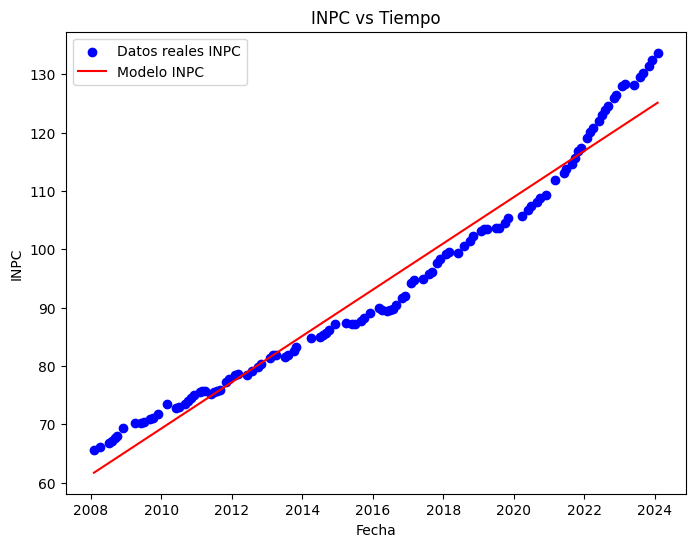

In [39]:
import matplotlib.pyplot as plt
import numpy as np

# INPC
plt.figure(figsize=(8, 6))
plt.scatter(tbl_econo_insights.index, y_inpc, color='blue', label='Datos reales INPC')
plt.plot(tbl_econo_insights.index, modelo_inpc.predict(), color='red', label='Modelo INPC')
plt.xlabel('Fecha')
plt.ylabel('INPC')
plt.title('INPC vs Tiempo')
plt.legend()
plt.show()


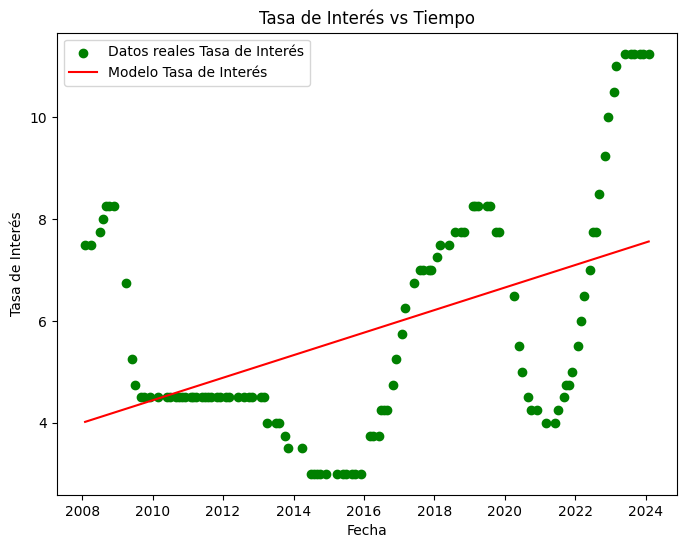

In [40]:

# Tasa de Interés
plt.figure(figsize=(8, 6))
plt.scatter(tbl_econo_insights.index, y_tasa_interes, color='green', label='Datos reales Tasa de Interés')
plt.plot(tbl_econo_insights.index, modelo_tasa_interes.predict(), color='red', label='Modelo Tasa de Interés')
plt.xlabel('Fecha')
plt.ylabel('Tasa de Interés')
plt.title('Tasa de Interés vs Tiempo')
plt.legend()
plt.show()


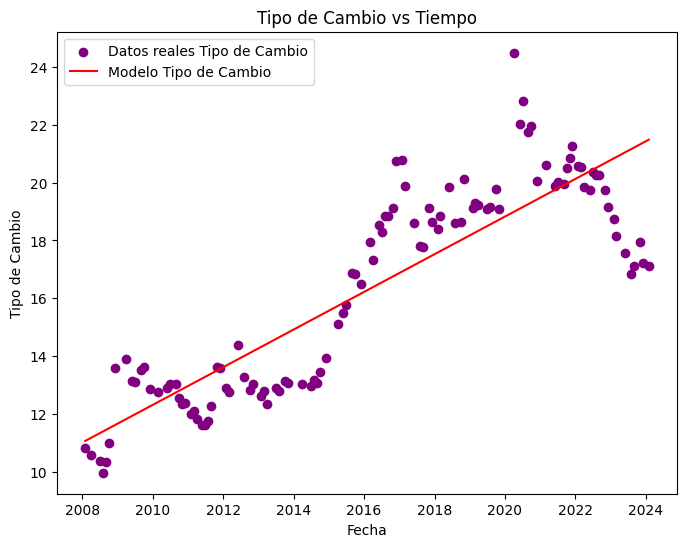

In [41]:

# Tipo de Cambio
plt.figure(figsize=(8, 6))
plt.scatter(tbl_econo_insights.index, y_tipo_cambio, color='purple', label='Datos reales Tipo de Cambio')
plt.plot(tbl_econo_insights.index, modelo_tipo_cambio.predict(), color='red', label='Modelo Tipo de Cambio')
plt.xlabel('Fecha')
plt.ylabel('Tipo de Cambio')
plt.title('Tipo de Cambio vs Tiempo')
plt.legend()
plt.show()
